In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from proofreader.utils.vis import plot_3d
import torch
%load_ext autoreload
%autoreload 2
%matplotlib inline

def plot_example(x,y=None,title=None, lim=0.1):
    if lim is not None:
        lim = (lim*-1,lim)
        lim = (lim,lim,lim)
    pc = np.swapaxes(x, 0, 1)
    t = ''
    if y is not None:
        t = y.item() == 1
    if title is not None:
        t = title
    plot_3d(pc, title=t, lims=lim)


In [ ]:
import torch
from proofreader.utils.vis import *
import numpy as np

# for i in range(1,6):
#     print('NUM SLICES: ', i)
path = f'/mnt/home/jberman/ceph/pf/dataset/DATASET_aligned_ns=1_cs=3_val.pt'
X, Y, I = torch.load(f'{path}')


In [ ]:
X, Y = torch.cat(X), torch.cat(Y)

In [ ]:
for i in range(40):
    plot_example(X[i], y=Y[i][0], lim=None)

In [ ]:
lens = []
for b in X:
    lens.append(len(b))
lens = np.array(lens)

# if Y[:,0][-1].item() != 1:
#     if Y[:,0].count_nonzero().item() != 0:
#         print(y[:,0])

cutoff = 8
p_sum = 0
for i in range(15):
    p = len(lens[lens==i])/len(lens)
    print(i, p)
    if i > cutoff:
        p_sum += p
print(cutoff, p_sum)
make_histogram(lens, bins=50)

In [ ]:
num_slices = 1
new_cs = 2
for i,x in enumerate(X[200:300]):
    x = x.numpy()
    d, n = x.shape
    z_cords = x[0,:]
    unique_z = np.unique(z_cords)
    drop_start = -1
    for j in range(len(unique_z)-1):
        if unique_z[j]+1 != unique_z[j+1]:
            drop_start = j+1
            break

    if drop_start == -1:
        print(f'could not find drop start for zs {unique_z}, coudl be issue with data')

    top_z, bot_z = unique_z[:drop_start], unique_z[drop_start:]
    top_labels = np.isin(z_cords, top_z).astype(float)
    bot_labels = np.isin(z_cords, bot_z).astype(float)

    print(top_labels)
    print(bot_labels)
    print(bot_labels.shape)




In [1]:
from proofreader.data.cremi import prepare_cremi_vols

train_vols, test_vols = prepare_cremi_vols('/mnt/home/jberman/sc/proofreader/dataset/cremi')

In [6]:
from proofreader.data.augment import Augmentor
from proofreader.data.splitter import SliceDataset

test_vol = test_vols[0].transpose()
print(test_vol.shape)
num_slices = 1
radius = 96
context_slices = 3
num_points = 2048
augmentor = Augmentor(center=True, shuffle=True,
                        normalize=(1250, 1250, 125))
dataset = SliceDataset([test_vol], num_slices, radius, context_slices, num_points=num_points, Augmentor=augmentor, truncate_candidates=0, candidate_group=False, scale=None, verbose=False, allow_multiple=True)
itr = dataset.__iter__()

(1250, 1250, 16)


{'top_class': 176, 'bot_class': 176, 'drop_start': 3, 'drop_end': 4, 'volume_i': 0, 'label': True}


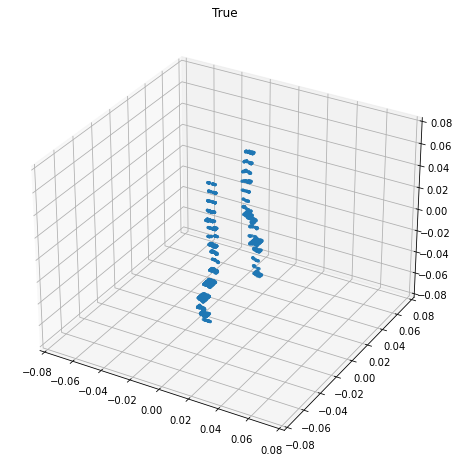

In [15]:
example = next(itr)
x, y, i = example
print(i)
plot_example(x, y=y, lim=0.08)